# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Lines** 


Couldn't find corners for image0
Couldn't find corners for image14
Couldn't find corners for image15


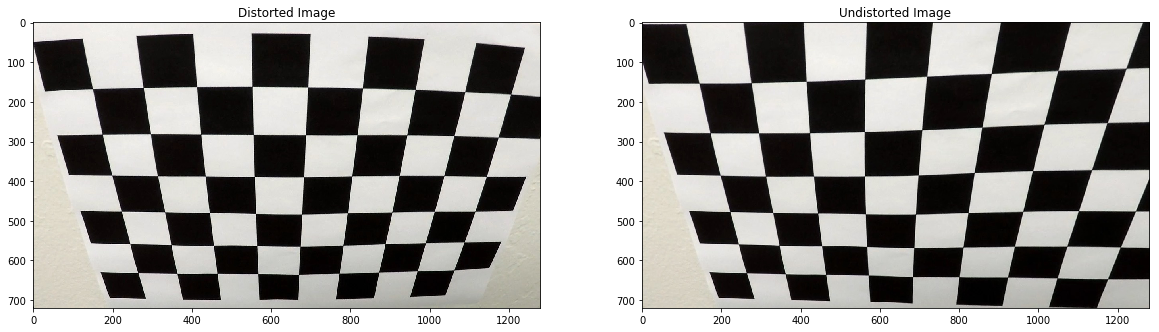

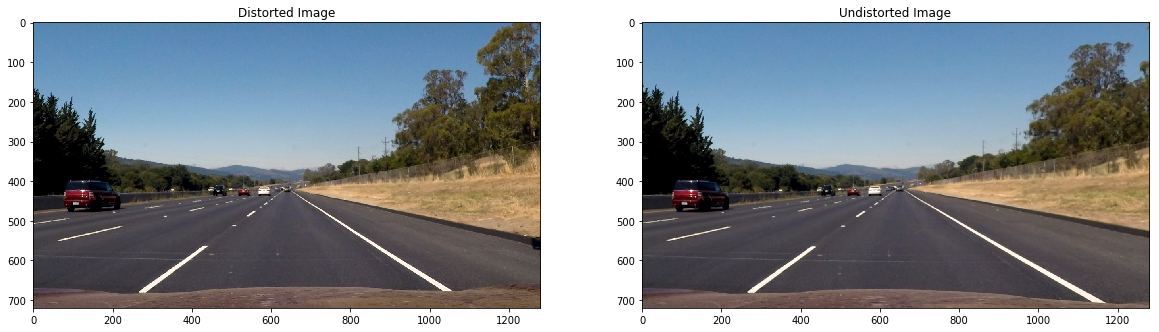

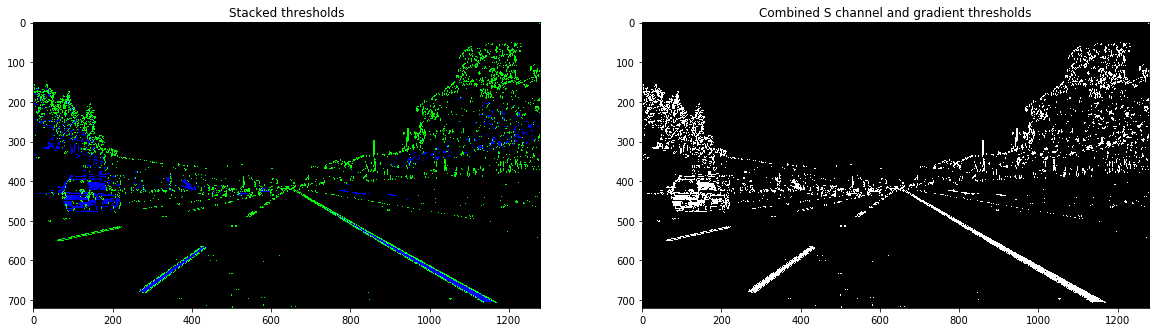

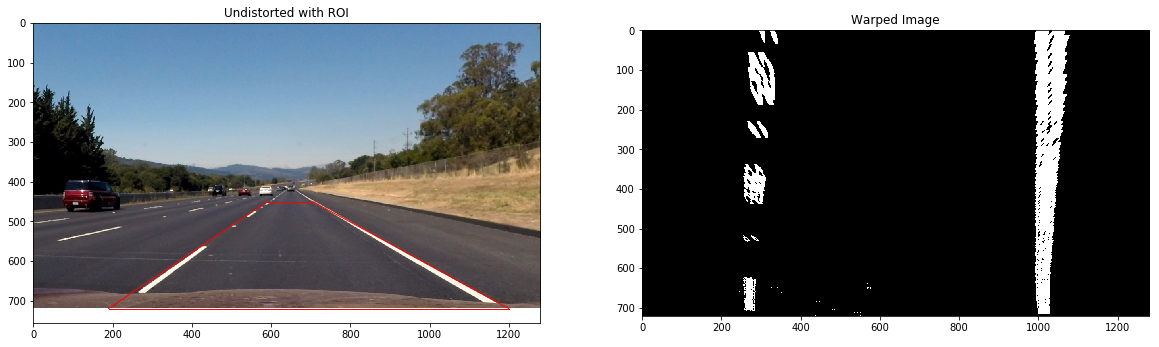

In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


def get_image_and_object_points(images, objpoints, imgpoints):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #write_name = 'corners_found'+str(idx)+'.jpg'
            #cv2.imwrite(write_name, img)
            #cv2.imshow('img', img)
    #         plt.figure()
    #         plt.imshow(img)
        else:
            print("Couldn't find corners for image" + str(idx))
            
    return img.shape[::-1]

def calibrate_camera(showImage=True):
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Get the chessboard corners.
    img_shape = get_image_and_object_points(images, objpoints, imgpoints)

    # Calibrate the camera.
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img_shape[0],img_shape[1]),None,None)
    
    if showImage:
        # Test the calibration by undistorting with the calculated parameters
        test_img = cv2.imread('camera_cal/calibration2.jpg')
        test_dist = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

        test_undist = cv2.undistort(test_dist, mtx, dist, None, mtx)

        # View the images for comparison
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('Distorted Image')
        ax1.imshow(test_dist)
        cv2.imwrite('./my_examples/distorted_test_image.jpg', cv2.cvtColor(test_dist, cv2.COLOR_BGR2RGB))

        ax2.set_title('Undistorted Image')
        ax2.imshow(test_undist)
        cv2.imwrite('./my_examples/undistorted_test_image.jpg', cv2.cvtColor(test_undist, cv2.COLOR_BGR2RGB))
        
    return mtx, dist

def s_color_and_gradient_threshold(img, thresh_min, thresh_max, s_thresh_min, s_thresh_max, showImage=True):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary*255, s_binary*255))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    if showImage:
        # Plotting thresholded images
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('Stacked thresholds')
        ax1.imshow(color_binary)
        cv2.imwrite('./my_examples/color_binary.jpg', cv2.cvtColor(color_binary, cv2.COLOR_BGR2RGB))

        ax2.set_title('Combined S channel and gradient thresholds')
        ax2.imshow(combined_binary, cmap='gray')
        cv2.imwrite('./my_examples/combined_binary.jpg', np.dstack(( combined_binary*255, combined_binary*255, combined_binary*255)))

    return combined_binary
    
def create_warped_image_and_display(img, matx, distM, showImage=True):
    # Test the calibration by undistorting with the calculated parameters
    undist = cv2.undistort(img, matx, distM, None, matx)

    if showImage:
        # View the images for comparison
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('Distorted Image')
        ax1.imshow(img)
        cv2.imwrite('./my_examples/distorted_image.jpg', cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        ax2.set_title('Undistorted Image')
        ax2.imshow(undist)
        cv2.imwrite('./my_examples/undistorted_image.jpg', cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))

    # Get lane pixels using color and gradient of lines.
    binary_lanes = s_color_and_gradient_threshold(undist, thresh_min = 20, thresh_max = 100, s_thresh_min = 170, s_thresh_max = 255, showImage=showImage)

    # Warp perspective
    # print(undist.shape)
    src = np.float32([[705, 450],[1200, 720],[190, 720], [590,450]])
    x = 250
    y = 0
    width = 780
    height = 720
    # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([[x+width,y],[x+width,y+height],[x,y+height],[x,y]])
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

    # get inverse transformation matrix
    Minv = cv2.getPerspectiveTransform(dst, src)

    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(binary_lanes, M, (binary_lanes.shape[1], binary_lanes.shape[0]), flags=cv2.INTER_LINEAR)

    if showImage:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('Undistorted with ROI')
        ax1.imshow(undist)
        ax1.plot((src[0][0],src[1][0]), (src[0][1],src[1][1]), color='r', linestyle='-', linewidth=1)
        ax1.plot((src[1][0],src[2][0]), (src[1][1],src[2][1]), color='r', linestyle='-', linewidth=1)
        ax1.plot((src[2][0],src[3][0]), (src[2][1],src[3][1]), color='r', linestyle='-', linewidth=1)
        ax1.plot((src[3][0],src[0][0]), (src[3][1],src[0][1]), color='r', linestyle='-', linewidth=1)

        ax2.set_title('Warped Image')
        ax2.imshow(warped, cmap='gray')
        cv2.imwrite('./my_examples/warped.jpg', np.dstack((warped*255, warped*255, warped*255)))

    return warped, undist, Minv
    
mtx, dist = calibrate_camera()
img = cv2.imread('test_images/straight_lines2.jpg')
img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
warped, undist, Minv = create_warped_image_and_display(img2, mtx, dist)

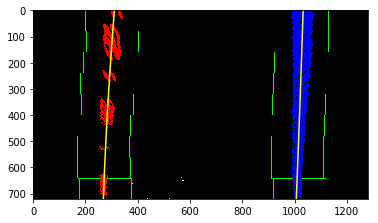

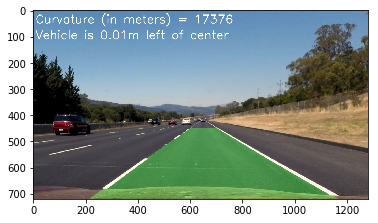

In [2]:
def sliding_window_fit_polynomial(binary_warped, undistorted, Minverse, showImage=True):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)    
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if showImage:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        cv2.imwrite('./my_examples/poly_fit.jpg', cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#     plt.figure()
#     plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minverse, (binary_warped.shape[1], binary_warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    img_bottom = warped.shape[0]-1
    left_lane_x = left_fit[0]*img_bottom**2 + left_fit[1]*img_bottom + left_fit[2]
    right_lane_x = right_fit[0]*img_bottom**2 + right_fit[1]*img_bottom + right_fit[2]
    car_center_offset = round(((right_lane_x + left_lane_x)/2 - warped.shape[1]/2)*xm_per_pix, 2)
    
    #print(right_lane_x, left_lane_x)
    
    # Fit new polynomials to x,y in world space
    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = warped.shape[0]-1 #np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Now our radius of curvature is in meters
    #print(round(left_curverad,0), 'm', round(right_curverad,0), 'm')
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Curvature (in meters) = {}'.format(int((left_curverad+right_curverad)/2)),(10,50), font, 1.5,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Vehicle is {}m {} of center'.format(abs(car_center_offset), 'left' if car_center_offset < 0 else 'right'),(10,110), font, 1.5,(255,255,255),2,cv2.LINE_AA)
    
    if showImage:
        plt.figure()
        plt.imshow(result)
        cv2.imwrite('./my_examples/result.jpg', cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        
    return result
    
# Fit a polynomial on the binary lines.
final_image = sliding_window_fit_polynomial(warped, undist, Minv)


## Test on Videos


In [3]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
mtx = None
dist = None

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    global mtx
    global dist
    
    # Fit a polynomial on the binary lines.
    if mtx is None or dist is None:
        mtx, dist = calibrate_camera(showImage=False)
    warped, undist, Minv = create_warped_image_and_display(image, mtx, dist, showImage=False)
    final_image = sliding_window_fit_polynomial(warped, undist, Minv, showImage=False)
    
    return final_image

In [ ]:
video_output = './my_examples/result_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

Couldn't find corners for image0
Couldn't find corners for image14
Couldn't find corners for image15
[MoviePy] >>>> Building video ./my_examples/result_video.mp4
[MoviePy] Writing video ./my_examples/result_video.mp4


 37%|███▋      | 467/1261 [00:55<01:29,  8.82it/s]

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

## Writeup

**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

[//]: # (Image References)

[image0a]: ./my_examples/distorted_test_image.jpg "Distorted Test Image"
[image0b]: ./my_examples/undistorted_test_image.jpg "Undistorted Test Image"
[image1]: ./my_examples/distorted_image.jpg "Distorted"
[image2]: ./my_examples/undistorted_image.jpg "Undistorted"
[image22]: ./test_images/test1.jpg "Road Transformed"
[image3a]: ./my_examples/color_binary.jpg "Color Binary"
[image3b]: ./my_examples/combined_binary.jpg "Combined Binary"
[image4]: ./my_examples/warped.jpg "Warped Image"
[image5]: ./my_examples/poly_fit.jpg "Poly Fit Visual"
[image6]: ./my_examples/result.jpg "Output"
[video1]: ./project_video.mp4 "Video"

## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points

### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

---

### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one. 

You're reading it!

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for this step is contained in the first code cell of the IPython notebook located in "./P4.ipynb".  The functions that performs parts of the calibration are:
- get_image_and_object_points()
- calibrate_camera()

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to a test image using the `cv2.undistort()` function.

Before:
![alt text][image0a]

After:
![alt text][image0b]


### Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.

Here is an example of the distorted (original) image:
![alt text][image1] 

And below is the undistorted image.
![alt text][image2]

You can see that the correction results in some parts of the image going out of the original boundary. Its like stretching the image.

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.

In function `s_color_and_gradient_threshold()`, which appears in the 1st code cell of this IPython notebook, I use thresholding on the S channel (of HLS) and sobel filter in the horizontal direction (x) to create a binary image. Here's an example of my output:

Binary Image:
![alt text][image3a]   

Combined binary Image:
![alt text][image3b]

#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform includes a function called `create_warped_image_and_display()`, which appears in the 1st code cell of this IPython notebook. I chose the hardcode the source and destination points in the following manner:

```python
src = np.float32([[705, 450],[1200, 720],[190, 720], [590,450]])
x = 250
y = 0
width = 780
height = 720
dst = np.float32([[x+width,y],[x+width,y+height],[x,y+height],[x,y]])
```

My source and destination points look like this:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 590, 450      | 250, 0        | 
| 190, 720      | 250, 720      |
| 1200, 720     | 1030, 720      |
| 705, 450      | 1030, 0        |

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

![alt text][image4]

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

Using the function `sliding_window_fit_polynomial()`, which appears in the 2nd code cell of this IPython notebook, I performed a sliding window search for lane pixels and later used it to fit a 2nd order polynomial. This polynomial gives me the curve of the lane line.  Since this is applied on the perspective corrected image, i.e. birds eye view, the curve reflects the actual curve on the ground and is not effected by the original perspective projection (where parallel lines may not remain parallel).  

Here is the output of the polynomial fitting.

![alt text][image5]

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

This also happend in the `sliding_window_fit_polynomial()` function, which appears in the 2nd code cell of this IPython notebook. The code for calculating the curvature is below:

```python
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    img_bottom = warped.shape[0]-1
    left_lane_x = left_fit[0]*img_bottom**2 + left_fit[1]*img_bottom + left_fit[2]
    right_lane_x = right_fit[0]*img_bottom**2 + right_fit[1]*img_bottom + right_fit[2]
    car_center_offset = round(((right_lane_x + left_lane_x)/2 - warped.shape[1]/2)*xm_per_pix, 2)
    
    # Fit new polynomials to x,y in world space
    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = warped.shape[0]-1 #np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Now our radius of curvature is in meters
    #print(round(left_curverad,0), 'm', round(right_curverad,0), 'm')
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Curvature (in meters) = {}'.format(int((left_curverad+right_curverad)/2)),(10,50), font, 1.5,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Vehicle is {}m {} of center'.format(abs(car_center_offset), 'left' if car_center_offset < 0 else 'right'),(10,110), font, 1.5,(255,255,255),2,cv2.LINE_AA)
```

Radius of curvature is calculated by the equation:

curve = ((1+(2Ay+B)^2)^3/2)/∣2A∣

The position of the vehicle is calculated by looking at the bottom most part of the left and right curves. Their x coordinates converted from pixels to meters gives the position w.r.t center of car.  These values are then superimposed on top of the image.

#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I implemented this also in the `sliding_window_fit_polynomial()` function, which appears in the 2nd code cell of this IPython notebook. 

Code for result plotting back onto road is below:

```python
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minverse, (binary_warped.shape[1], binary_warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
```

Here is an example of my result on a test image:
![alt text][image6]

---

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to my video result](./my_examples/result_video.mp4)

---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Had some issues with the RGB vs. BGR format the different apis use for images read (e.g. video processing was using different format) but it was solved easily.

If the car ever moves out of a lane so that the projection corrected image does not show to lane lines, then the solution would break down.

Also the solution will need to be tested in night conditions as that is as important as daylight testing.  